# Useful references

## Python + Numpy + Matplotlib + etc.

* Python Numpy Tutorial: http://cs231n.github.io/python-numpy-tutorial/
* Computational Statistics in Python: https://people.duke.edu/~ccc14/sta-663/
* Numpy for MATLAB users: https://docs.scipy.org/doc/numpy-dev/user/numpy-for-matlab-users.html
* MATLAB synonymous commands in Python/NumPy: http://mathesaurus.sourceforge.net/

## NEURON (with Python)
* NEURON documentation: https://www.neuron.yale.edu/neuron/static/py_doc/index.html
* NEURON + Python tutorial: https://neuron.yale.edu/neuron/static/docs/neuronpython/index.html

## NMODL
* NEURON Extension to NMODL: https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl2.html
* NMODL: https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl.html#nmodl


In [1]:
%%bash

# Don't forget compiling mod files.

cd mod.files
nrnivmodl

Creating x86_64 directory for .o files.

/root/Documents/class_4/mod.files
ConnorStevens.mod MorrisLecar.mod adexp.mod ccstdpsyn.mod netstim2.mod wb.mod
ConnorStevens.mod MorrisLecar.mod adexp.mod ccstdpsyn.mod netstim2.mod wb.mod
"/usr/local/nrn/x86_64/bin/nocmodl" ConnorStevens
"/usr/local/nrn/x86_64/bin/nocmodl" MorrisLecar
"/usr/local/nrn/x86_64/bin/nocmodl" adexp
"/usr/local/nrn/x86_64/bin/nocmodl" ccstdpsyn
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -O3 -fPIC -fno-strict-aliasing -msse3 -c -o MorrisLecar.lo MorrisLecar.c
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -O3 -fPIC -fno-strict-aliasing -msse3 -c -o ConnorStevens.lo ConnorStevens.c
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nr

Translating MorrisLecar.mod into MorrisLecar.c
Translating ConnorStevens.mod into ConnorStevens.c
Translating adexp.mod into adexp.c
Translating ccstdpsyn.mod into ccstdpsyn.c
Thread Safe
Thread Safe
Thread Safe
Thread Safe
Translating netstim2.mod into netstim2.c
Translating wb.mod into wb.c
 Multistep integrators (such as Runge) may not work correctly.
Thread Safe
Thread Safe


# 1. Cell objects

**Make sure that you reset the kernel at this point.** 

In Python, you can define custom data types that you can use to organize data and related operations. For example, so far we have worked with cell models in NEURON, which have common attributes and operations as:

1. Sections and segments,
2. Combining sections to define the morphology of a cell,
3. Active mechanisms and inserting them,
4. Synapses and connecting them to other cells, etc.


We can collect these into a cell object as follows:

In [2]:
from neuron import h, gui
from neuron import load_mechanisms

import numpy as np
import matplotlib.pyplot as plt
load_mechanisms('./mod.files')


class Cell:
    """ Cell class"""
    
    # When a cell object is created this function is called first.
    # Note "self" in definition
    def __init__(self):
        
        self.synlist = []      # list of synapses in this cell

        # here are some operations to create a cell
        self.create_sections()
        self.build_topology()
        self.build_subsets()
        self.define_geometry()
        self.define_biophysics()
        self.create_synapses()

    # At this stage, we leave most of them unimplemented
    # This technique is called "the Template Method pattern" (https://sourcemaking.com/design_patterns/template_method)
    def create_sections(self):
        raise NotImplementedError("create_section() is not implemented.")

    def build_topology(self):
        raise NotImplementedError("build_topology() is not implemented.")
    
    def build_subsets(self):
        raise NotImplementedError("build_subsets() is not implemented.")

    def define_geometry(self):
        raise NotImplementedError("define_geometry() is not implemented.")

    def define_biophysics(self):
        raise NotImplementedError("define_biophysics() is not implemented.")

    def create_synapses(self):
        raise NotImplementedError("create_synapses() is not implemented.")
    
    # Here are something that will be commonly used by every cell
    # built based on this template
    
    def connect2target(self, target, thresh=0):
        """Make a new NetCon with this cell's membrane
        potential at the soma as the source (i.e. the spike detector)
        onto the target passed in (i.e. a synapse on a cell).
        Subclasses may override with other spike detectors."""
        nc = h.NetCon(self.soma(1)._ref_v, target, sec = self.soma)
        nc.threshold = thresh
        return nc

In [3]:
cell1 = Cell()

NotImplementedError: create_section() is not implemented.

In [4]:
class ConnorStevens(Cell):
    
    def create_sections(self):
        """create a soma"""
        self.soma = h.Section(name="soma", cell=self)

    def build_topology(self):
        pass # single compartment
    
    def build_subsets(self):
        pass # single compartment
    
    def define_geometry(self):
        self.soma.L = 15
        self.soma.diam = 15

    def define_biophysics(self):
        h.v_init = -65
        self.soma.insert('conste')

    def create_synapses(self):
        self.synlist.append(h.Exp2Syn(self.soma(0.5))) # Excitatory
        self.synlist[-1].e = 0
        self.synlist[-1].tau1 = 0.1
        self.synlist[-1].tau2 = 2.0
        
        self.synlist.append(h.Exp2Syn(self.soma(0.5))) # Inhibitory     
        self.synlist[-1].e = -75
        
        # Here we use the same temporal parameters as excitatory synapses
        self.synlist[-1].tau1 = 0.1
        self.synlist[-1].tau2 = 2.0

In [5]:
cell1 = ConnorStevens() # this should work

In [6]:
cell1.soma.psection()

{'point_processes': {'Exp2Syn': {Exp2Syn[1], Exp2Syn[0]}},
 'density_mechs': {'conste': {'gl': [0.0003],
   'el': [-70.0],
   'gnabar': [0.12],
   'gkbar': [0.02],
   'gabar': [0.0477],
   'gna': [0.0],
   'gk': [0.0],
   'ga': [0.0],
   'il': [0.0],
   'm': [0.0],
   'h': [0.0],
   'n': [0.0],
   'a': [0.0],
   'b': [0.0]}},
 'ions': {'na': {'ena': [50.0],
   'nai': [10.0],
   'nao': [140.0],
   'ina': [0.0],
   'dina_dv_': [0.0]},
  'k': {'ek': [-77.0],
   'ki': [54.4],
   'ko': [2.5],
   'ik': [0.0],
   'dik_dv_': [0.0]}},
 'morphology': {'L': 15.0,
  'diam': [15.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 35.4,
 'cm': [1.0]}

In [8]:
cell1.synlist[0].e

0.0

# 2. Network simulation

**Make sure that you reset the kernel at this point.** 

Here we will show how organize the network simulation code by using classes and objects. We prepared the `Cell` class in `cell_template.py` and define the `ConnorStevens` once again using the class.

In [1]:
from neuron import h, gui
from neuron import load_mechanisms

import numpy as np
import matplotlib.pyplot as plt
load_mechanisms('./mod.files')

from cell_template import Cell

class ConnorStevens(Cell):
    
    def create_sections(self):
        """create a soma"""
        self.soma = h.Section(name="soma", cell=self)

    def build_topology(self):
        pass # single compartment
    
    def build_subsets(self):
        pass # single compartment
    
    def define_geometry(self):
        self.soma.L = 15
        self.soma.diam = 15

    def define_biophysics(self):
        h.v_init = -65
        self.soma.insert('conste')

    def create_synapses(self):
        self.synlist.append(h.Exp2Syn(self.soma(0.5))) # Excitatory
        self.synlist[-1].e = 0
        self.synlist[-1].tau1 = 0.1
        self.synlist[-1].tau2 = 2.0
        
        self.synlist.append(h.Exp2Syn(self.soma(0.5))) # Inhibitory     
        self.synlist[-1].e = -75
        
        # Here we use the same temporal parameters as excitatory synapses
        self.synlist[-1].tau1 = 0.1
        self.synlist[-1].tau2 = 2.0

Now, we will build a network model based on this cell type. The network contains 1000 cells and 20% of the neurons are inhibitory while the rest is excitatory. Each cell randomly pulls inputs from 10% of the excitatory and inhibitory cell population.

In [2]:
Ncells = 1000                    # Number of cells
Nexc = int((Ncells/5)*4)         # Excitatory cells = 80%
Ninh = int(Ncells/5)             # Inhibitory cells = 20%
nexcpre = int(Nexc*0.1)          # Presynaptic excitatory cells for each neuron = 10% of excitatory cells
ninhpre = int(Ninh*0.1)  # Presynaptic inhibitory cells for each neuron = 10% of inhibitory cells

print('Ncells =', Ncells, '\nNexc =', Nexc, '\nNinh =', Ninh, '\nnexcpre =',nexcpre, '\nninhpre =', ninhpre)

Ncells = 1000 
Nexc = 800 
Ninh = 200 
nexcpre = 80 
ninhpre = 20


We use `SerialNetManager` from `net_manager` module, which will make building, running, and saving the data easier.

In [3]:
from net_manager import SerialNetManager

pnm = SerialNetManager(Ncells)

In [4]:
for i in range(Ncells):
    pnm.register_cell(i, ConnorStevens())

Then, we connect an external stimulus to each neuron, which will *kickstart* the network activity.

In [5]:
ics = []
for i in range(Ncells):
    ic = h.NetStimFD(pnm.gid2cell[i].soma(0.5))
    ic.interval = 3
    ic.noise = 1
    ic.start = 0
    ic.duration = 7
    ic.seed(i+1223)
    
    nc = h.NetCon(ic, pnm.gid2cell[i].synlist[0])
    nc.weight[0] = 5e-3
    ics.append((ic, nc))


Then we let the network manager know that we will record spikes from all the cells.

In [6]:
pnm.want_all_spikes()

We haven't wired the cells yet, but the neurons will fire with external stimuli. Let's try a short simulation!

In [7]:
h.tstop = 50
h.init()
pnm.run()

[Text(0,0.5,'Neuron'), (0, 50), Text(0.5,0,'Time (ms)')]

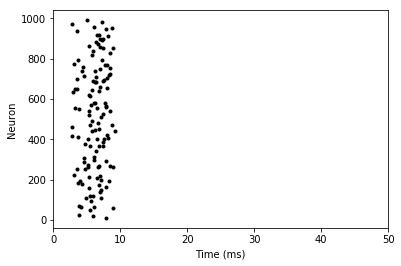

In [10]:
fig, ax = plt.subplots()
ax.plot(pnm.spikevec, pnm.idvec, '.k')
ax.set(xlabel='Time (ms)', ylabel='Neuron', xlim=[0, 50])

Now we wire the cells:

In [11]:
gexc = 3e-3     # g_exc = 3 nS
ginh = 5.*gexc   # g_inh/g_exc = 5

# Reset all NetCon's
pnm.nc_reset()

# Go around every cell
for i in range(Ncells):
    
    # Choose nexcpre cells from Nexc excitatory cells
    exc_pre = np.random.randint(0, Nexc, nexcpre)
    # Choose ninhpre cells from Ninh inhibitory cells
    inh_pre = np.random.randint(Nexc, Ncells, ninhpre)

    for k in exc_pre:
        if i!=k:  # No self-connection
            # pnm.nc_append(id_of_presyn_cell, id_of_postsyn_cell, synapse_id, syn_weight, propagation_delay, threshold)
            pnm.nc_append(k, i, 0, gexc, 0.1, thresh=-10)

    for k in inh_pre:
        if i!=k:  # No self-connection
            pnm.nc_append(k, i, 1, ginh, 0.1, thresh=-10)

In [ ]:
#This part is for changing the synaptic conductance!

# gexc_o = gexc
# ginh_o = ginh

# gexc = 1.5e-3
# ginh = 5*gexc

# gexc = 4e-3
# ginh = 3*gexc

for k in pnm.netcons:
    if pnm.netcons[k].weight[0]==gexc_o:
        pnm.netcons[k].weight[0] = gexc
    if pnm.netcons[k].weight[0]==ginh_o:
        pnm.netcons[k].weight[0] = ginh
        
# for k in pnm.netcons:
#     print(pnm.netcons[k].e)

Let's run it!

In [12]:
h.tstop = 250
h.init()
pnm.run()

[Text(0,0.5,'Neuron'), Text(0.5,0,'Time (ms)')]

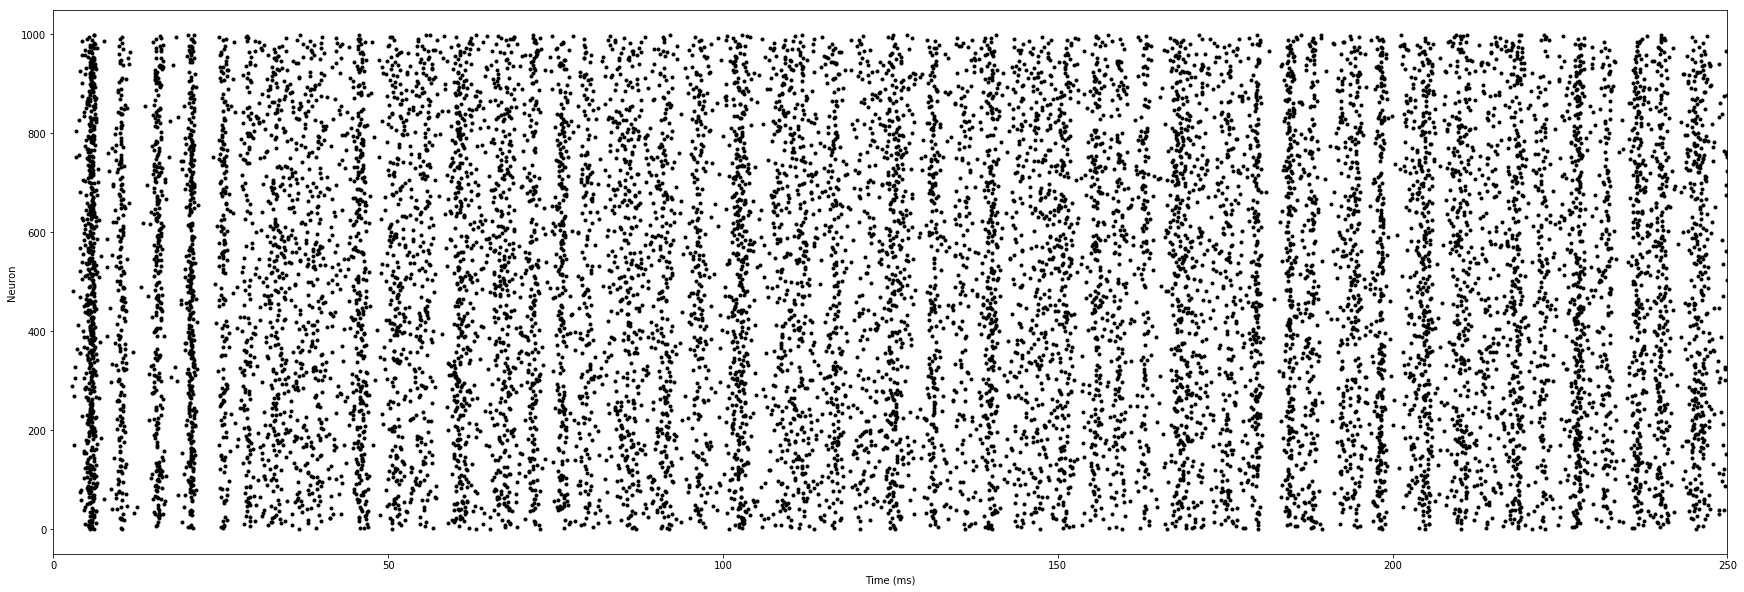

In [13]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.plot(pnm.spikevec, pnm.idvec, '.k')
ax.set(xlim=[0, h.tstop])
ax.set(xlabel='Time (ms)', ylabel='Neuron')

Since the simulation becomes considerably slow, we may want to run it by using multiple cores and/or computers. In NEURON, we can do this by using the MPI-based parallelization, but we cannot run this in a notebook. So we will dump our simulation to a Python script, and run it instead.

In [14]:
%%file parallel_simulation.py

import numpy as np
from neuron import h
from neuron import load_mechanisms

load_mechanisms('./mod.files')

from cell_template import Cell
class ConnorStevens(Cell):

    def __init__(self, i):
        # We initialize the cell as in the `Cell` class.
        super().__init__()
        
        # Then, we can add additional operations,
        # such as giving each cell its own "kickstart" stimulator,
        self.stim = []
        self.stim.append(h.NetStimFD(self.soma(0.5)))
        self.stim[-1].interval = 3
        self.stim[-1].noise = 1
        self.stim[-1].start = 0
        self.stim[-1].duration = 7
        self.stim[-1].seed(i+1223)

        self.stim.append(h.NetCon(self.stim[0], self.synlist[0]))
        self.stim[-1].weight[0] = 5e-3

    def create_sections(self):
        """create a soma"""
        self.soma = h.Section(name="soma", cell=self)

    def build_topology(self):
        pass # single compartment

    def build_subsets(self):
        pass # single compartment

    def define_geometry(self):
        self.soma.L = 15
        self.soma.diam = 15

    def define_biophysics(self):
        h.v_init = -65
        self.soma.insert('conste')

    def create_synapses(self):
        self.synlist.append(h.Exp2Syn(self.soma(0.5))) # Excitatory
        self.synlist[-1].tau1 = 0.1
        self.synlist[-1].tau2 = 2.0
        self.synlist[-1].e = 0

        self.synlist.append(h.Exp2Syn(self.soma(0.5))) # Inhibitory
        self.synlist[-1].e = -75
        self.synlist[-1].tau1 = 0.1
        self.synlist[-1].tau2 = 2.0


Ncells = 1000                    # Number of cells
Nexc = int((Ncells/5)*4)         # Excitatory cells = 80%
Ninh = int(Ncells/5)             # Inhibitory cells = 20%
nexcpre = int(Nexc*0.1)
ninhpre = int(Ninh*0.1)


from net_manager import ParallelNetManager # Note we are using the parallel version
pnm = ParallelNetManager(Ncells)

for i in range(Ncells):
    pnm.register_cell(i, ConnorStevens(i))

    
gexc = 3e-3      # g_exc = 3 nS
ginh = 7.*gexc   # g_inh/g_exc = 7


for i in pnm.gidlist:
    exc_pre = np.random.randint(0, Nexc, nexcpre)     # Randomly choose 10% of the exc cells
    inh_pre = np.random.randint(Nexc, Ncells, ninhpre) # Randomly choose 10% of the inh cells

    for k in exc_pre:
        if i!=k:  # No self-connection
            pnm.nc_append(k, i, 0, gexc, 0.1, thresh=-10)

    for k in inh_pre:
        if i!=k:  # No self-connection
            pnm.nc_append(k, i, 1, ginh, 0.1, thresh=-10)

pnm.want_all_spikes(thresh=-10)
pnm.set_output_filename('spikes_1.dat')

h.tstop = 250
h.init()
pnm.run()

pnm.message("Simulation complete!")

h.quit()

Writing parallel_simulation.py


In [15]:
%%bash

mpirun -np 4 nrngui -python -mpi parallel_simulation.py

numprocs=4
Simulation complete!


Unexpected end of /proc/mounts line `overlay / overlay rw,relatime,lowerdir=/var/lib/docker/overlay2/l/PAYIRZCWMFO2KQVQ65OZHFZWOT:/var/lib/docker/overlay2/l/J5MG3NVM2Q56N63AISXMTPZW7S:/var/lib/docker/overlay2/l/A6VTZSWQUR3QKPFMH5GDJQ3MB3:/var/lib/docker/overlay2/l/VXOPCXTJZVM2K2JBXMDCMTSKVW:/var/lib/docker/overlay2/l/U2477IY63BLYEP3EEJ3TKUJOEW:/var/lib/docker/overlay2/l/J54LIM6FRMJ65CV6CXT7F2CUGP:/var/lib/docker/overlay2/l/YQRWPJWTZYT32Z7IDV5LAGDLDT:/var/lib/docker/overlay2/l/D6332GYJD5WPNCRUBXJ5NV26NJ:/var/lib/docker/overlay2/l/2NS2TY47HGBDO'
Unexpected end of /proc/mounts line `YYC5W2AZQWFGN:/var/lib/docker/overlay2/l/3AOBCOPHDXBWTYX6C5L25MD5SY:/var/lib/docker/overlay2/l/2GQCWM3EZLY3NCGG74IEJHE2L3:/var/lib/docker/overlay2/l/EKSQG5JIMN2KGFJEFK6UJ2UVHG:/var/lib/docker/overlay2/l/FLFK5P2UKE4TZBSRR6WF4KE6BX:/var/lib/docker/overlay2/l/ZMK57LAUK5ETQOZ6KWXLATBAXY:/var/lib/docker/overlay2/l/L472XWY4ZQLBE7N2RIMFJHCFKX:/var/lib/docker/overlay2/l/QDRSQ6XFRBWO6NHLEGSS3J7FU5:/var/lib/docker/overl

Now we load the data and view the result:

[Text(0,0.5,'Neuron'), Text(0.5,0,'Time (ms)')]

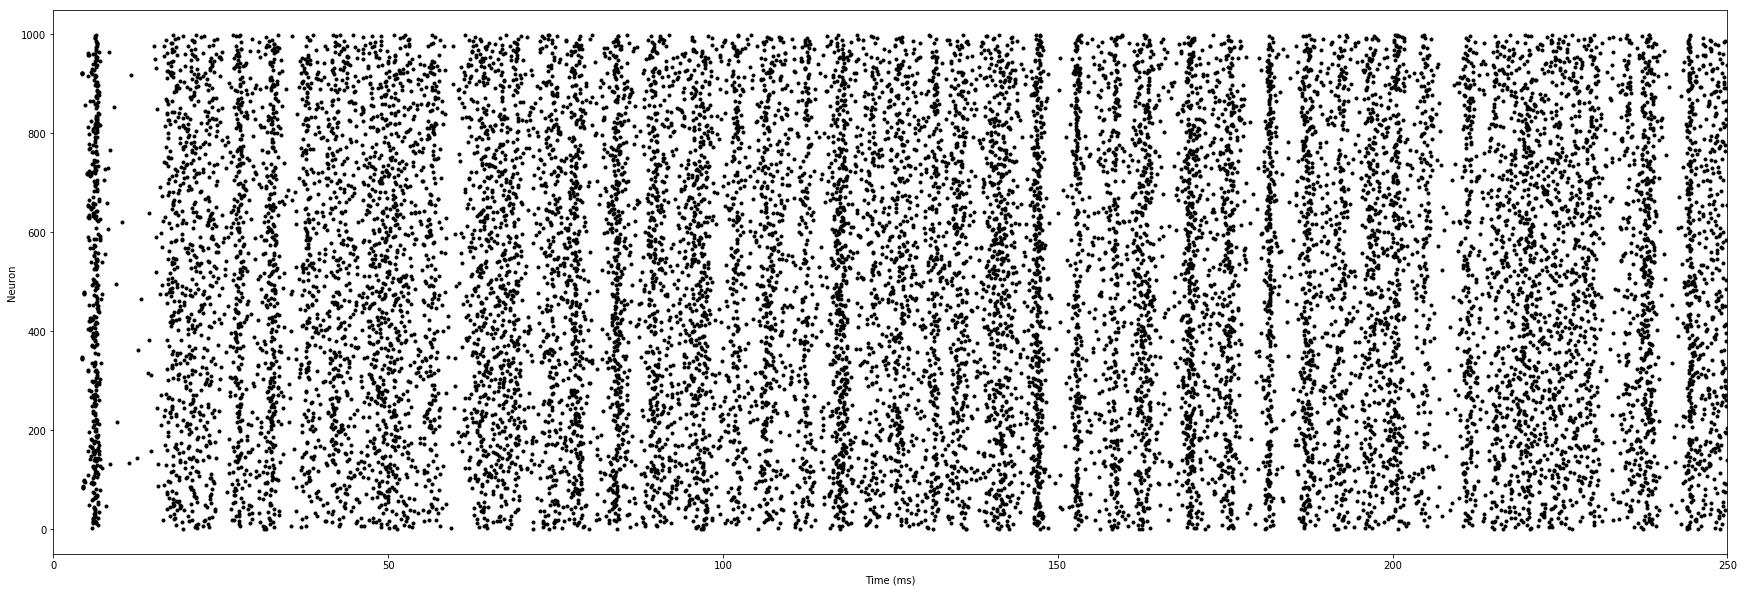

In [16]:
x = np.loadtxt('spikes_1.dat', delimiter=',')

_, ax = plt.subplots(figsize=(30,10))
ax.plot(x[:,0], x[:,1], '.k')
ax.set(xlim=[0, 250])
ax.set(xlabel='Time (ms)', ylabel='Neuron')

## Analyzing data

In most cases, we convert spike time data into spike train histograms with time bins.

[Text(0,0.5,'spikes'), (0, 250), Text(0.5,0,'time (ms)')]

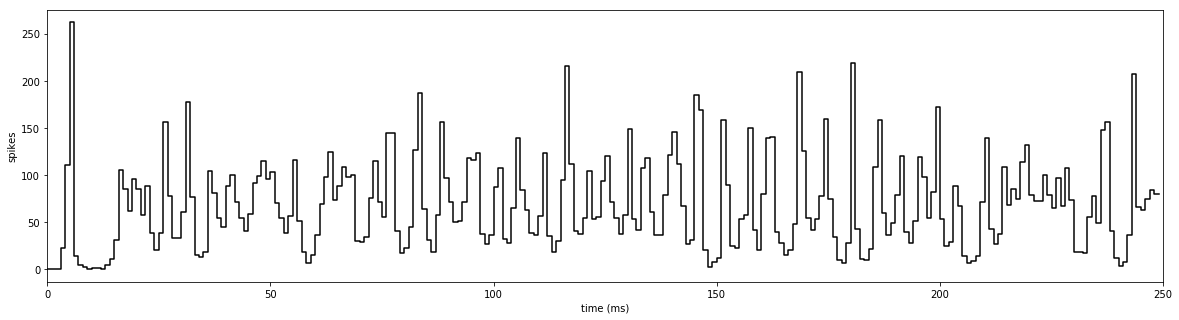

In [17]:
tstop = 250
tc = np.arange(tstop+1)
spikecount_all, _ = np.histogram(x[:,0], tc)
t = tc[:-1]

_, ax = plt.subplots(figsize=(20, 5))
ax.step(t, spikecount_all, 'k')
ax.set(xlim=[0, tstop], xlabel='time (ms)', ylabel='spikes')

Making spike trains for individual neurons is also straightforward.

[Text(0,0.5,'neuron'), (0, 250), Text(0.5,0,'time (ms)')]

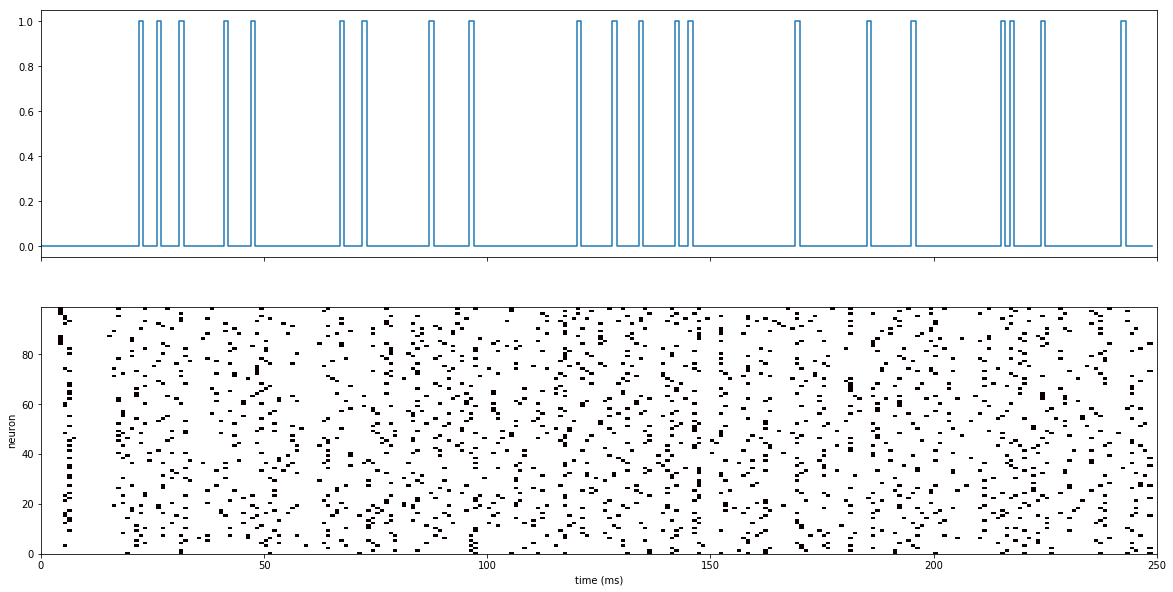

In [18]:
spiketrain = np.zeros((spikecount_all.size, Ncells))

for i in range(Ncells):
    iselect = (x[:, 1] == i)
    spiketrain[:, i], _ = np.histogram(x[iselect, 0], tc)
    
_, ax = plt.subplots(nrows=2, figsize=(20, 10), sharex=True)

ax[0].step(t, spiketrain[:,10])
ax[0].set(xlim=[0, tstop])

ax[1].pcolormesh(t, np.arange(100), spiketrain[:,:100].T, cmap='hot_r')
ax[1].set(xlim=[0, tstop],
       xlabel='time (ms)',
       ylabel='neuron')

Noticing transient oscillations in our data, we can try analysis in a frequency domain.

[(0, 250),
 Text(0,0.5,'frequency (Hz)'),
 (0, 250),
 Text(0.5,0,'time (ms)'),
 Text(0.5,1,'Spectrogram')]

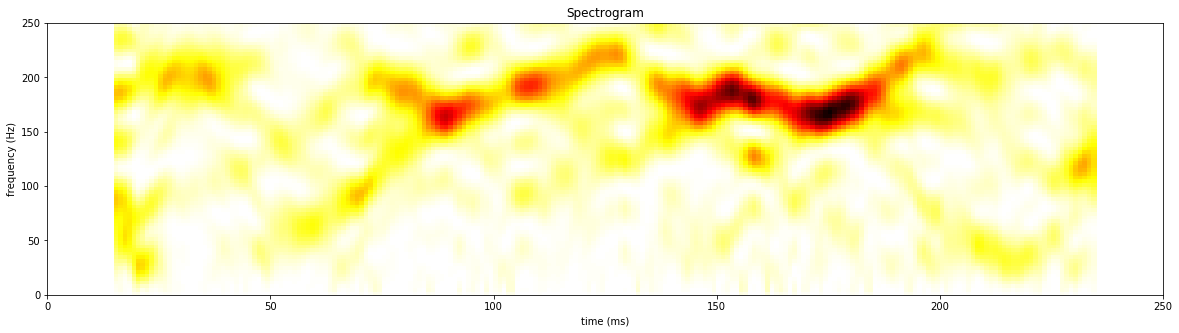

In [19]:
import scipy.signal

freqs, tz, spectrogram = scipy.signal.spectrogram(
    spikecount_all*1000,
    fs=1000,
    window=('tukey',0.25),
    nperseg=30,
    noverlap=29,
    nfft=300
)

_, ax = plt.subplots(figsize=(20, 5))
ax.pcolormesh(tz*1000, freqs, spectrogram,
               cmap='hot_r')
ax.set(title='Spectrogram',
    ylabel='frequency (Hz)',
    xlabel='time (ms)',
    ylim=[0, 250],
    xlim=[0, tstop])


# External inputs

Neural networks are not isolated entities. They are always under influence of external inputs, and here we add two more cell groups that will deliver external inputs to our network.

In [20]:
%%file parallel_simulation_2.py

import numpy as np
from neuron import h
from neuron import load_mechanisms

load_mechanisms('./mod.files')

from cell_template import Cell

class ConnorStevens(Cell):
    
    def create_sections(self):
        """create a soma"""
        self.soma = h.Section(name="soma", cell=self)

    def build_topology(self):
        pass # single compartment

    def build_subsets(self):
        pass # single compartment

    def define_geometry(self):
        self.soma.L = 15
        self.soma.diam = 15

    def define_biophysics(self):
        h.v_init = -65
        self.soma.insert('wb')

    def create_synapses(self):
        self.synlist.append(h.Exp2Syn(self.soma(0.5))) # Excitatory
        self.synlist[-1].tau2 = 0.1
        self.synlist[-1].tau2 = 2.0
        self.synlist[-1].e = 0

        self.synlist.append(h.Exp2Syn(self.soma(0.5))) # Inhibitory
        self.synlist[-1].e = -75
        self.synlist[-1].tau1 = 0.1
        self.synlist[-1].tau2 = 2.0

        
class NetworkCell(ConnorStevens):
    def __init__(self, i):
        super().__init__()

        # Note that each network cell has its own "kickstart" stimulator
        self.stim = []
        self.stim.append(h.NetStimFD(self.soma(0.5)))
        self.stim[-1].interval = 3
        self.stim[-1].noise = 1
        self.stim[-1].start = 0
        self.stim[-1].duration = 5
        self.stim[-1].seed(i+1223)

        self.stim.append(h.NetCon(self.stim[0], self.synlist[0]))
        self.stim[-1].weight[0] = 1.5e-4


class ExternalCell(ConnorStevens):
    def __init__(self, i):
        super().__init__()

        # Each external cell has 
        self.stim = []
        self.stim.append(h.NetStimFD(self.soma(0.5)))
        self.stim[-1].interval = 5
        self.stim[-1].noise = 1
        self.stim[-1].start = 100
        self.stim[-1].duration = 50
        self.stim[-1].seed(i+209)

        self.stim.append(h.NetCon(self.stim[-1], self.synlist[0]))
        self.stim[-1].weight[0] = 5e-4


Ncells = 1000                    # Number of cells
Nexc = int((Ncells/5)*4)         # Excitatory cells = 80%
Ninh = int(Ncells/5)             # Inhibitory cells = 20%
nexcpre = int(Nexc*0.1)
ninhpre = int(Ninh*0.1)

Nleft = 100

from net_manager import ParallelNetManager # Note we are using the parallel version
pnm = ParallelNetManager(Ncells+Nleft)

for i in range(Ncells):
    pnm.register_cell(i, NetworkCell(i))

for i in range(Nleft):
    pnm.register_cell(i+Ncells, ExternalCell(i+Ncells))
    
gexc = 3e-5   # g_exc = 3 nS
ginh = 7*gexc #12   # g_inh/g_exc = 7

# Within network connectivity
pcl = 0.65
nexcpre1 = int(pcl*nexcpre)
nexcpre2 = nexcpre - nexcpre1
print(nexcpre1, nexcpre2)

pcl = 0.55
ninhpre1 = int(pcl*ninhpre)
ninhpre2 = ninhpre - ninhpre1
print(ninhpre1, ninhpre2)


for i in pnm.gidlist:
    if (i<Nexc/2):
        exc_pre = np.random.randint(0, Nexc/2, nexcpre1)
        for k in exc_pre:
            if i!=k:  # No self-connection
                pnm.nc_append(k, i, 0, gexc, 0.1, thresh=0)
                
        exc_pre = np.random.randint(Nexc/2, Nexc, nexcpre2)
        for k in exc_pre:
            if i!=k:  # No self-connection
                pnm.nc_append(k, i, 0, gexc, 0.1, thresh=0)

        inh_pre = np.random.randint(Nexc, Nexc+Ninh/2, ninhpre1)
        for k in inh_pre:
            if i!=k:  # No self-connection
                pnm.nc_append(k, i, 1, ginh, 0.1, thresh=0)

        inh_pre = np.random.randint(Nexc+Ninh/2, Ncells, ninhpre2) # Randomly choose 10% of the inh cells
        for k in inh_pre:
            if i!=k:  # No self-connection
                pnm.nc_append(k, i, 1, ginh, 0.1, thresh=0)


    if (i>=Nexc/2) and (i<Nexc):
        exc_pre = np.random.randint(0, Nexc/2, nexcpre2)
        for k in exc_pre:
            if i!=k:  # No self-connection
                pnm.nc_append(k, i, 0, gexc, 0.1, thresh=0)
                
        exc_pre = np.random.randint(Nexc/2, Nexc, nexcpre1)
        for k in exc_pre:
            if i!=k:  # No self-connection
                pnm.nc_append(k, i, 0, gexc, 0.1, thresh=0)
                
        inh_pre = np.random.randint(Nexc, Nexc+Ninh/2, ninhpre2)
        for k in inh_pre:
            if i!=k:  # No self-connection
                pnm.nc_append(k, i, 1, ginh, 0.1, thresh=0)

        inh_pre = np.random.randint(Nexc+Ninh/2, Ncells, ninhpre1) # Randomly choose 10% of the inh cells
        for k in inh_pre:
            if i!=k:  # No self-connection
                pnm.nc_append(k, i, 1, ginh, 0.1, thresh=0)
                
                
    if (i>=Nexc) and (i<Nexc+Ninh/2): # Only network cells
        exc_pre = np.random.randint(0, Nexc/2, nexcpre1)
        for k in exc_pre:
            if i!=k:  # No self-connection
                pnm.nc_append(k, i, 0, gexc, 0.1, thresh=0)
                
        exc_pre = np.random.randint(Nexc/2, Nexc, nexcpre2)
        for k in exc_pre:
            if i!=k:  # No self-connection
                pnm.nc_append(k, i, 0, gexc, 0.1, thresh=0)


        inh_pre = np.random.randint(Nexc, Ncells, ninhpre) # Randomly choose 10% of the inh cells
        for k in inh_pre:
            if i!=k:  # No self-connection
                pnm.nc_append(k, i, 1, ginh, 0.1, thresh=0)


                
    if (i>=Nexc+Ninh/2) and (i<Ncells): # Only network cells
        exc_pre = np.random.randint(0, Nexc/2, nexcpre2)
        for k in exc_pre:
            if i!=k:  # No self-connection
                pnm.nc_append(k, i, 0, gexc, 0.1, thresh=0)
                
        exc_pre = np.random.randint(Nexc/2, Nexc, nexcpre1)
        for k in exc_pre:
            if i!=k:  # No self-connection
                pnm.nc_append(k, i, 0, gexc, 0.1, thresh=0)

        inh_pre = np.random.randint(Nexc, Ncells, ninhpre) # Randomly choose 10% of the inh cells
        for k in inh_pre:
            if i!=k:  # No self-connection
                pnm.nc_append(k, i, 1, ginh, 0.1, thresh=0)



                
n_ext = 4    # Each network cell in the Left group gets inputs from 10 external cells
gext = 5e-5   # with the excitatory conductance of 3 nS

for i in pnm.gidlist:
    if (i<Nexc/2) or (i>=Nexc and i<(Nexc+Ninh/2)): # A half of the network cells
        exc_pre = np.random.randint(Ncells, Ncells+Nleft, n_ext)     # Randomly choose next external cells

        for k in exc_pre:
            if i!=k:  # No self-connection
                pnm.nc_append(k, i, 0, gext, 0.1, thresh=-10)

# for i in pnm.gidlist:
#     if (i>=Nexc/2 and i<Nexc) or (i>=(Nexc+Ninh/2) and i<Ncells): # A half of the network cells
#         exc_pre = np.random.randint(Ncells+Nleft/3, Ncells+Nleft, n_ext)     # Randomly choose next external cells

#         for k in exc_pre:
#             if i!=k:  # No self-connection
#                 pnm.nc_append(k, i, 0, gext, 0.1, thresh=-10)
                

pnm.want_all_spikes(thresh=-10)
pnm.set_output_filename('spikes_2.dat')

h.tstop = 500
h.init()
pnm.run()

pnm.message("Simulation complete!")

h.quit()

Writing parallel_simulation_2.py


In [21]:
%%bash

mpirun -np 4 nrngui -python -mpi parallel_simulation_2.py

numprocs=4
52 28
11 9
52 28
11 9
52 28
11 9
52 28
11 9
Simulation complete!


Unexpected end of /proc/mounts line `overlay / overlay rw,relatime,lowerdir=/var/lib/docker/overlay2/l/PAYIRZCWMFO2KQVQ65OZHFZWOT:/var/lib/docker/overlay2/l/J5MG3NVM2Q56N63AISXMTPZW7S:/var/lib/docker/overlay2/l/A6VTZSWQUR3QKPFMH5GDJQ3MB3:/var/lib/docker/overlay2/l/VXOPCXTJZVM2K2JBXMDCMTSKVW:/var/lib/docker/overlay2/l/U2477IY63BLYEP3EEJ3TKUJOEW:/var/lib/docker/overlay2/l/J54LIM6FRMJ65CV6CXT7F2CUGP:/var/lib/docker/overlay2/l/YQRWPJWTZYT32Z7IDV5LAGDLDT:/var/lib/docker/overlay2/l/D6332GYJD5WPNCRUBXJ5NV26NJ:/var/lib/docker/overlay2/l/2NS2TY47HGBDO'
Unexpected end of /proc/mounts line `YYC5W2AZQWFGN:/var/lib/docker/overlay2/l/3AOBCOPHDXBWTYX6C5L25MD5SY:/var/lib/docker/overlay2/l/2GQCWM3EZLY3NCGG74IEJHE2L3:/var/lib/docker/overlay2/l/EKSQG5JIMN2KGFJEFK6UJ2UVHG:/var/lib/docker/overlay2/l/FLFK5P2UKE4TZBSRR6WF4KE6BX:/var/lib/docker/overlay2/l/ZMK57LAUK5ETQOZ6KWXLATBAXY:/var/lib/docker/overlay2/l/L472XWY4ZQLBE7N2RIMFJHCFKX:/var/lib/docker/overlay2/l/QDRSQ6XFRBWO6NHLEGSS3J7FU5:/var/lib/docker/overl

Let's load the data and inspect the result!

[Text(0,0.5,'Neuron'), Text(0.5,0,'Time (ms)')]

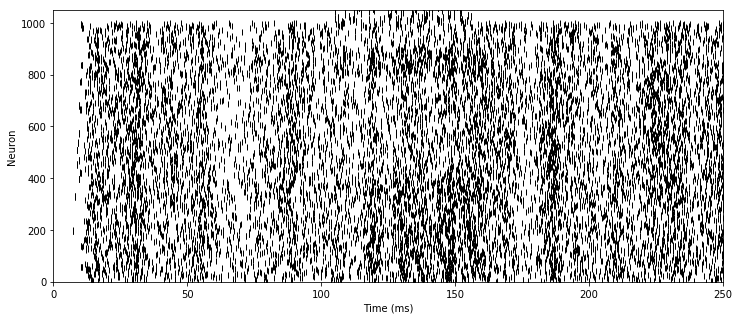

In [22]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

x = np.loadtxt('spikes_2.dat', delimiter=',')

_, ax = plt.subplots(figsize=(12,5))
ax.plot(x[:,0], x[:,1], '|k')
ax.set(xlim=[0, 250], ylim=[0, 1050])
ax.set(xlabel='Time (ms)', ylabel='Neuron')

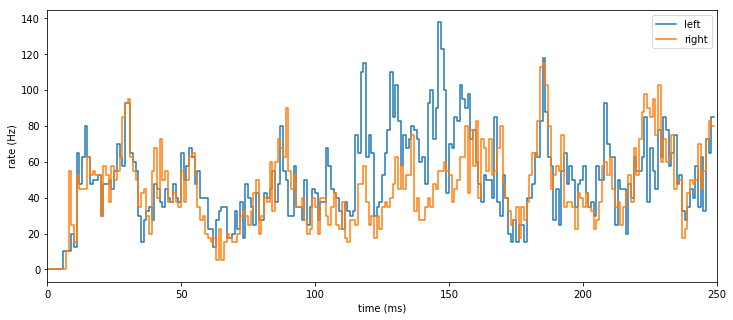

In [23]:
Ncells = 1000
tstop = 250
tc = np.arange(250+1)
t = tc[:-1]
x = x[x[:,1]<1000,:] # work only with network cells
spiketrain = np.zeros((250, Ncells))

for i in range(Ncells):
    iselect = (x[:, 1] == i)
    spiketrain[:, i], _ = np.histogram(x[iselect, 0], tc)
    
_, ax = plt.subplots(nrows=1, sharex=True, figsize=(12, 5))
ax = [ax]
z = spiketrain[:,:400].mean(axis=1)*1000-spiketrain[:,400:800].mean(axis=1)*1000
# z = z*(z>0)
ax[0].step(t, spiketrain[:,:400].mean(axis=1)*1000, label="left")
ax[0].step(t, spiketrain[:,400:800].mean(axis=1)*1000, label="right")
# ax[0].step(t, z)
ax[0].set(xlim=[0, tstop],
       xlabel='time (ms)',
       ylabel='rate (Hz)')
plt.legend()